# Exercise 13: Structured light
Imports

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import cv2 
from scipy.optimize import least_squares
from scipy.spatial.transform import Rotation
# from Helperfunctions import *
from glob import glob
import skimage
from glob import glob

In [2]:
def pi(points : np.ndarray) -> np.ndarray:
    """
        Converts from homogeneous to inhomogeneous coordinates
    """
    p = points[:-1]/points[-1]
    
    return p

def load_im(path : str) -> np.ndarray:
    """
        Returns:
            Image scaled to float.
    """
    im = cv2.imread(path)[:, :, ::-1]
    im = im.astype(np.float64) / 255
    
    return im

Load calibration of kamera

In [3]:
CASPER_PATH = "../Data/Week_13/"
c = np.load(CASPER_PATH + "calib.npy", allow_pickle=True).item()


## Exercise 13.1
I am tired....

## Exercie 13.2
First we need to rectify the images. First run the following code to initialize the maps for rectifi- cation

In [4]:
CASPER_PATH = "../Data/Week_13/"

im0 = cv2.imread(CASPER_PATH + "sequence/frames0_0.png")

size = (im0.shape[1], im0.shape[0])
stereo = cv2.stereoRectify(c['K0'], c['d0'], c['K1'],
                           c['d1'], size, c['R'], c['t'], flags=0)
R0, R1, P0, P1 = stereo[:4]
n1, n2 = 40, 41

NUM_MAPS = 2

maps = [None] * NUM_MAPS   # <-- This is just for initialization - a list of two elements

maps[0] = cv2.initUndistortRectifyMap(c['K0'], c['d0'], R0, P0, size, cv2.CV_32FC2)
maps[1] = cv2.initUndistortRectifyMap(c['K1'], c['d1'], R1, P1, size, cv2.CV_32FC2)

You can now rectify images by doing `cv2.remap(im, *maps, cv2.INTER_LINEAR)`, where maps is either maps0 or maps1 depending on which camera the image is coming from. This also handles the undistortion of the images. `P0` and `P1` are the projection matrices for the rectified images, which will come in handy when we need to triangulate the points in 3D.

These are saved into to lists `ims0` for the first camera and `ims` for the second camera


In [5]:
NUM_IMS = 25

ims = [[],[]]
# We skip the first two images, because they are something which is fully illuminated and something which is fully dark
for i in range(NUM_IMS + 1):
    # There are two maps
    for j in range(2):
        filename = CASPER_PATH + f"sequence/frames{j}_{i}.png"
        im = cv2.imread(filename)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        im_remap = cv2.remap(im, map1 = maps[j][0], map2 = maps[j][1], interpolation = cv2.INTER_LINEAR)
        # print(f"ReMapped: '{filename}'")
        ims[j].append(im_remap)

ims0, ims1 = ims


Print the first one

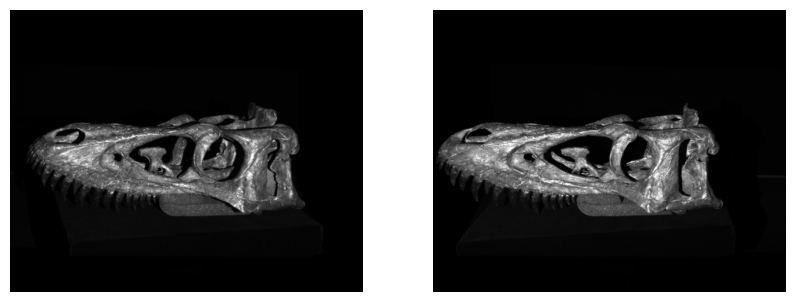

In [6]:

plt.figure(figsize=(10,30))
plt.subplot(1,2,1)
plt.imshow(ims0[0],cmap='gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(ims1[0],cmap='gray')
plt.axis('off')
plt.show()

# Exercise 13.3
At this point, we are ready to make a function that can compute the phases for each camera theta = unwrap(ims).

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


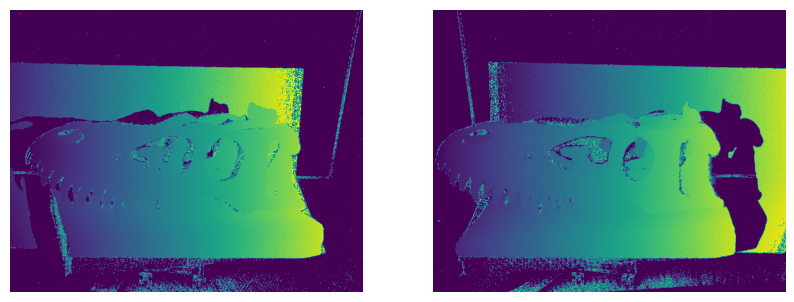

In [13]:
def unwrap(ims):
    primary_ims = ims[2:18]
    fft_primary = np.fft.rfft(primary_ims,axis=0)
    theta_primary = np.angle(fft_primary[1])

    secondary_ims = ims[18:]
    fft_secondary = np.fft.rfft(secondary_ims,axis=0)
    theta_secondary = np.angle(fft_secondary[1])

    theta_c = (theta_secondary - theta_primary)  
    print(theta_c)
    o_primary = np.rint((n1*theta_c-theta_primary)/(2*np.pi))
    thetas = ((2*np.pi*o_primary+theta_primary)/(n1)) % (2*np.pi)

    return thetas

# Compute
thetas0 = unwrap(ims0)
thetas1 = unwrap(ims1)

# Plot
plt.figure(figsize=(10,30))
plt.subplot(1,2,1)
plt.imshow(thetas0)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(thetas1)
plt.axis('off')
plt.show()


## Exercise 13.4
Make a mask

Max: ims0: 255, ims1: 255


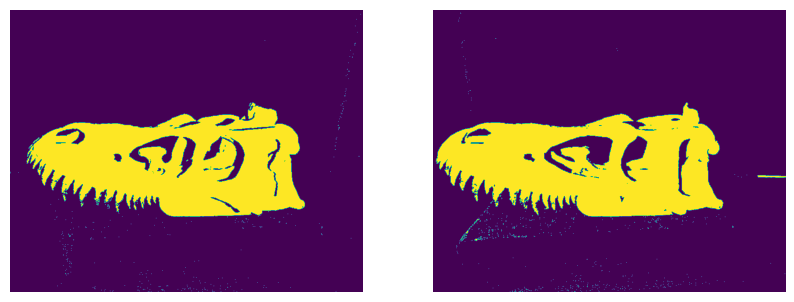

In [8]:
THRESHOLD = 15
print(f"Max: ims0: {np.max(ims0[0])}, ims1: {np.max(ims1[0])}")

mask0 = (ims0[0] - ims0[1]) >= THRESHOLD
mask1 = (ims1[0] - ims1[1]) >= THRESHOLD
# Plot
plt.figure(figsize=(10,30))
plt.subplot(1,2,1)
plt.imshow(mask0)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(mask1)
plt.axis('off')
plt.show()

## Exercise 13.5
Now we need to find matches between the two cameras

-21.0
-21.0


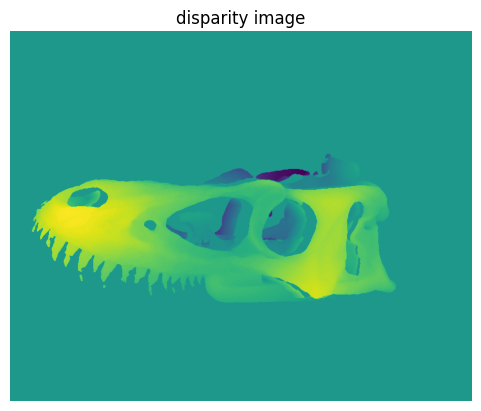

In [12]:

points0= np.array(np.where(mask0)).T
disparity = np.zeros((size[0],size[1]))


q0s = []
q1s = []

for [i0,j0] in points0:
    theta1_vals = thetas1[i0,:]
    mask1_row = mask1[i0,:]
    if np.sum(mask1_row):
        k = np.argmin(abs(theta1_vals[mask1_row] - thetas0[i0,j0]))
        idx = np.where(mask1_row)[0][k]
        q0s.append([i0,j0])
        q1s.append([i0,idx])
    

disparity_im = np.zeros((size[1], size[0]))
for i in range(len(q0s)):
    i0 = q0s[i][0]
    j0 = q0s[i][1]
    j1 = q1s[i][1]
    disparity_im[i0,j0] = j0 - j1
        
q0s = np.array(q0s).astype(float).T
q1s = np.array(q1s).astype(float).T

fig, ax = plt.subplots()
print(disparity_im[360, 400])
disparity_im = cv2.medianBlur(disparity_im.astype(np.float32), 5)
print(disparity_im[360, 400])
ax.imshow(disparity_im)
ax.axis('off')
ax.set_title('disparity image')
plt.show()


## Exercise 13.6
Use triangulate to visualize in 3d. 


In [10]:
import open3d as o3d



print(f"q0s: {q0s.shape}")
Q = pi(cv2.triangulatePoints(P0, P1, q0s, q1s))
print(Q.shape)
Q = Q[:, Q[2,:] > 0]
print(Q.shape)


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
q0s: (2, 112377)
(3, 112377)
(3, 112377)


In [11]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(Q.T)
o3d.visualization.draw_geometries([pcd])